# Iniciación en Python con Aplicaciones en Aceración (día 03)

**Dr. Edgar Ivan Castro Cedeño**

[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import desulf # funciones propias
from scipy.integrate import solve_ivp

# 4. Cálculo de la tasa de desulfuración

## 4.1 Ecuación diferencial de la tasa de desulfuración

La ecuación de diferencial de primer orden que se muestra debajo, permite estimar el progreso de la desulfuración de un baño de acero, considerando que al mismo tiempo que el azufre es removido del metal, el contenido de azufre en la escoria aumenta.


$$\frac{d[\%S]}{dt} = -k_{S,emp} \left([\%S] \left(1 + \frac{1}{\frac{M_{sl}}{1000} L_s} \right) - \frac{[\%S_0]}{\frac{M_{sl}}{1000} L_s}\right) $$


donde:

- $k_{S, emp}$: constante de desulfuración empírica que caracteriza el nivel de agitación en el baño y la extensión del área de contacto entre el metal y la escoria

- $[\%S]$: contenido de azufre en el metal.

- $[\%S_0]$: contenido de azufre inicial.

- $M_{sl}$: masa de escoria, en kg/ton.

- $L_S$: coeficiente de reparto de azufre.

In [2]:
def desulfRate(t:float, wS:float, c:float) -> float:
    ks, wS0, Msl, Ls = c
    Y = Msl/1000 * Ls
    return -ks * (wS * (1 + 1/Y) - wS0/Y)

## 4.2 Resolución numérica de la ecuación diferencial

Se utiliza la función `solve_ivp()`, incluida en la librería `scipy.integrate` para efectuar la resolución numérica de la ecuación diferencial planteada en la función `desulfRate`.

In [3]:
# definir tiempos para integración y constantes
ks = 1e-3 # constante de desulfuración, [1/s]
wS0 = 0.020 #valor inicial de azufre, [wt%]
Msl = 20 # masa de escoria, kg/ton
Ls = 50 # coeficiente de reparto

In [13]:
# definir tiempos para integración y constantes
ks = 1e-3 # constante de desulfuración, [1/s]
wS0 = 0.020 #valor inicial de azufre, [wt%]
Msl = 20 # masa de escoria, kg/ton
Ls = 50 # coeficiente de reparto

# entrada para el resolvedor
teval = np.linspace(0, 3600, 121)
tspan = (teval[0], teval[-1])
c = [ks, wS0, Msl, Ls]

# resolver la ecuacion diferencial
sol1 = solve_ivp((lambda t, wS: desulf.desulfRate(t, wS, c)), 
                t_span=tspan, y0 = [wS0], t_eval=teval)

# ver el objeto `sol` que contiene la solución
print(sol1)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.000e+01 ...  3.570e+03  3.600e+03]
        y: [[ 2.000e-02  1.942e-02 ...  1.001e-02  1.001e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0


In [16]:
# definir tiempos para integración y constantes
ks = 1e-3 # constante de desulfuración, [1/s]
wS0 = 0.020 #valor inicial de azufre, [wt%]
Msl = 20 # masa de escoria, kg/ton
Ls = 100 # coeficiente de reparto


# entrada para el resolvedor
teval = np.linspace(0, 3600, 121)
tspan = (teval[0], teval[-1])
c = [ks, wS0, Msl, Ls]

# resolver la ecuacion diferencial
sol2 = solve_ivp((lambda t, wS: desulf.desulfRate(t, wS, c)), 
                t_span=tspan, y0 = [wS0], t_eval=teval)

# ver el objeto `sol` que contiene la solución
print(sol2)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.000e+01 ...  3.570e+03  3.600e+03]
        y: [[ 2.000e-02  1.941e-02 ...  6.731e-03  6.728e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0


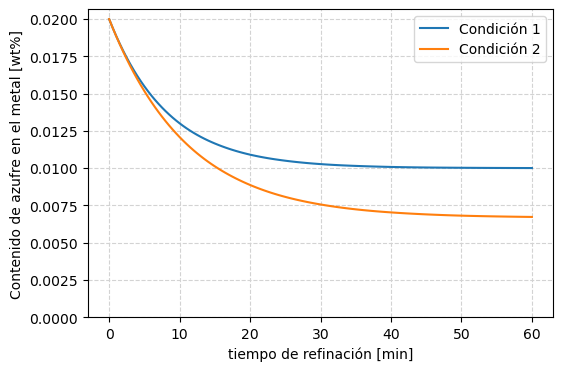

In [17]:
# graficando los resultados
fig, ax = plt.subplots(figsize=(6, 4))


# perfil de desulfuracion 1
t = sol1.t/60 # tiempo,[min]
wS = sol1.y[0] # azufre al tiempo t, [wt%]
ax.plot(t, wS, label='Condición 1')

# perfil de desulfuracion 2
t = sol2.t/60 # tiempo, [min]
wS = sol2.y[0] # azufre al tiempo t, [wt%]
ax.plot(t, wS, label='Condición 2')


ax.set_xlabel("tiempo de refinación [min]")
ax.set_ylabel("Contenido de azufre en el metal [wt%]")

ax.grid(ls='--', color='lightgray')
ax.legend()

ax.set_ylim(0,)

plt.show()

## 4.3 Refinación del modelo

Hasta el momento, se ha resuelto la ecuación diferencial considerando que los parámetros, $k_{S,emp}$, y $L_S$, fueron determinados previamente por el utilizador.

$$\frac{d[\%S]}{dt} = -k_{S,emp} \left([\%S] \left(1 + \frac{1}{\frac{M_{sl}}{1000} L_s} \right) - \frac{[\%S_0]}{\frac{M_{sl}}{1000} L_s}\right) $$

### 4.3.1 Cálculo fino del coeficiente de reparto de azufre

$$\log L_S = \underbrace{\log C_S -\frac{935}{T} + 1.375}_{\log C_S'} + \log f_S - \log h_O$$

**Modelo para la capacidad de sulfuros (Zhang et al. (2013))**

En este modelo, la capacidad de sulfuros se relaciona con la basicidad óptica de la escoria, $\Lambda$ y la temperatura, $T$.

$$\Lambda = \frac{\sum X_i n_i \Lambda_{th,i}}{\sum{X_i n_i}}$$

donde:

- $X_i$: fracción molar de cada molécula, e.g., $\mathrm{Al_2O_3}$, $\mathrm{SiO_2}$, etc.
- $n_i$: número de aniones de oxígeno en la molécula, e.g., $3$ para $\mathrm{Al_2O_3}$, y $2$ para $\mathrm{SiO_2}$.
- $\Lambda_{th,i}$: basicidad óptica teórica para cada molécula.

In [18]:
def opticalBasicity(slagComp: dict, T: float) -> float:
    
    ### Constants for calculation
    molarMass = {'Al2O3': 101.9613, 'CaO': 56.0794, 'MgO': 40.3014, 'SiO2': 60.0843, 'FeO': 71.8464, 'MnO': 70.9374}
    anions = {'Al2O3': 3, 'CaO': 1, 'MgO': 1, 'SiO2': 2, 'FeO': 1, 'MnO': 1}
    ### Basicities of molecules (could be modified...)
    lambTh = {'Al2O3': 0.66, 'CaO': 1.0, 'MgO': 0.92, 'SiO2': 0.47, 'FeO': 0.94, 'MnO': 0.95} ## (A.Ghosh, Sec. Steelmaking, App.2.4)
    #### Mass pct of components in slag
    slagW = np.asarray([slagComp['Al2O3'], slagComp['CaO'], slagComp['MgO'], slagComp['SiO2'], slagComp['FeO'], slagComp['MnO']])
    #### slag molar masses
    slagM = np.asarray([molarMass['Al2O3'], molarMass['CaO'], molarMass['MgO'], molarMass['SiO2'], molarMass['FeO'], molarMass['MnO']])
    #### slag number of oxygen anions
    slagA = np.asarray([anions['Al2O3'], anions['CaO'], anions['MgO'], anions['SiO2'], anions['FeO'], anions['MnO']])
    #### slag basicity of components
    slagLamb = np.asarray([lambTh['Al2O3'], lambTh['CaO'], lambTh['MgO'], lambTh['SiO2'], lambTh['FeO'], lambTh['MnO']])
    ### Molar fraction of components in slag
    slagX = (slagW/slagM) / np.sum(slagW/slagM)
    return np.sum(slagX * slagA * slagLamb) / np.sum(slagX * slagA)

La capacidad de sulfuros está dada por la ecuación:

$$\log C_S = -6.08 + \frac{4.49}{\Lambda} + \frac{\left(15893 - \frac{15864}{\Lambda} \right)}{T}$$

donde:

- $\Lambda$: basicidad óptica de la escoria.
- $T$: Temperatura, en $\mathrm{K}$

In [19]:
def logCs(slagComp, T):   
    lamb = opticalBasicity(slagComp, T)
    return -6.08 + 4.49/lamb + (15893 - 15864/lamb)/T

### 4.3.2 Cálculo fino de la constante de desulfuración

**Constante de desulfuración**

La constante de desulfuración, $k_S$ es proporcional a la potencia de agitación específica en la olla de acero, $\dot{\varepsilon}$.

$$
\begin{matrix}
k_{S}\,[\mathrm{min^{-1}}]  = 0.013\left(\dot{\varepsilon}\right)^{0.25} & \forall & \dot{\varepsilon} < [\mathrm{60\,W.ton^{-1}]} \\
k_{S}\,[\mathrm{min^{-1}}]  = 8\times10^{-6}\left(\dot{\varepsilon}\right)^{2.1} & \forall & \dot{\varepsilon} \ge [\mathrm{60\,W.ton^{-1}]} \\
\end{matrix}
$$

In [20]:
def kSCalc(eps):
   return 1/60 * ((eps<60)*0.013*(eps)**(0.25) + (eps>=60)*8e-6*(eps)**(2.1))

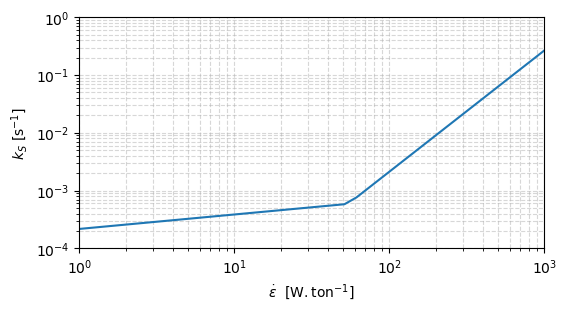

In [21]:
fig, ax = plt.subplots(figsize=(6, 3))

eps = np.linspace(1, 1000, 100)
kS = desulf.kSCalc(eps)
ax.plot(eps, kS)

# format
ax.set_xlabel(r'$\dot{\varepsilon}$  [$\mathrm{W.ton^{-1}}$]')
ax.set_xscale('log')
ax.set_xlim(1, 1000)
ax.set_ylabel(r"$k_S$ [$\mathrm{s^{-1}}$]")
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
ax.grid(ls='--', which='both', alpha=0.5)
plt.show()

**Potencia de agitación**

La potencia de agitación se puede estimar con la siguiente ecuación:

$$\dot{\varepsilon} = 14.23\left(\frac{\dot{V}T}{M}\right) \log \left(\frac{1+H}{1.48 P_0}\right)$$

donde:

- $\dot{\varepsilon}$: potencia de agitación, en $[\mathrm{W.ton^{-1}}]$.
- $\dot{V}$: Flujo volumétrico de gas de agitación, en $[\mathrm{Nm^3.min^{-1}}]$.
- $T$: Temperatura del baño, en $[\mathrm{K}]$.
- $M$: Masa del baño, en $[\mathrm{ton}]$.
- $H$: Profundidad de inyección de gas, en $[\mathrm{m}]$.
- $P_0$: Presión de gas en la superficie del baño, en $[\mathrm{atm}]$.

In [ ]:
def stirPowerCalc(V, T, M, H, P0):
    return 14.23 * (V*T/M) * np.log10((1+H)/(1.48*P0))

## 4.4 Utilización del modelo refinado

In [24]:
# condiciones de proceso
V = 0.240 # flujo de gas [Nm3.min-1]
T = 1873 # Temperatura [K]
M = 150 # masa del baño de acero [ton]
H = 2 # profundidad de inyección de gas [m]
P0 = 1 # presión sobre el baño, [atm]

# condiciones del metal
wS0 = 0.020 #valor inicial de azufre, [wt%]
fS = 1 # coeficiente de actividad de azufre
aO = 0.0002 # actividad de oxígeno

# condiciones de la escoria
Msl = 20 # masa de escoria, kg/ton
slag =  {'Al2O3': 33,  # composición, wt%
         'CaO': 57, 
         'MgO': 5, 
         'SiO2': 5, 
         'FeO': 0, 
         'MnO': 0
}

In [25]:
# Cálculo de constante de desulfuración
eps = desulf.stirPowerCalc(V, T, M, H, P0) # potencia agitación [W.ton-1]
ks = desulf.kSCalc(eps)
print("ks = {:.4e} [s-1]".format(ks))

ks = 4.1209e-04 [s-1]


In [26]:
# Cálculo del coeficiente de reparto
logCs = desulf.logCs(slag, T)
Cs = np.power(10, logCs)
print("log(Cs) = {:.4f}".format(logCs))
logLs = desulf.logLs(Cs, T, fS, aO)
Ls = np.power(10, logLs)
print("Ls = {:.2f}".format(Ls))

log(Cs) = -2.4960
Ls = 119.88


In [27]:
# entrada para el resolvedor
teval = np.linspace(0, 3600, 121)
tspan = (teval[0], teval[-1])
c = [ks, wS0, Msl, Ls]

# resolver la ecuacion diferencial
sol3 = solve_ivp((lambda t, wS: desulf.desulfRate(t, wS, c)), 
                t_span=tspan, y0 = [wS0], t_eval=teval)

# ver el objeto `sol` que contiene la solución
print(sol3)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.000e+01 ...  3.570e+03  3.600e+03]
        y: [[ 2.000e-02  1.975e-02 ...  7.644e-03  7.613e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0


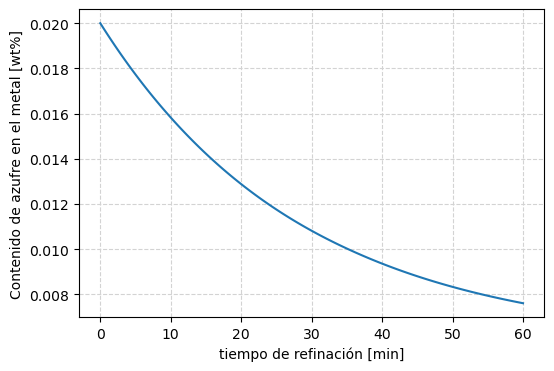

In [28]:
# graficando los resultados
fig, ax = plt.subplots(figsize=(6, 4))

t = sol3.t/60 # tiempo,[min]
wS = sol3.y[0] # azufre al tiempo t, [wt%]

ax.plot(t, wS)
ax.set_xlabel("tiempo de refinación [min]")
ax.set_ylabel("Contenido de azufre en el metal [wt%]")

ax.grid(ls='--', color='lightgray')

## 4.5 Referencias

[Slag Atlas (1995)](https://www.stahleisen.de/product/slag-atlas/)  
ed. by VDEh. Verlag Stahleisen GmbH, Düsseldorf.

[The Making, Shaping and Treating of Steel: Steelmaking and Refining Volume (1998)](https://imis.aist.org/store/detail.aspx?id=PB-332)  
ed. by R. J. Fruehan, Association of Iron and Steel Engineers.

[Andersson M.A., Jönsson P.G., Nzotta M.M. (1999)](https://www.jstage.jst.go.jp/article/isijinternational1989/39/11/39_11_1140/_pdf)  
Application of the sulphide capacity concept on high-basicity ladle slags used in bearing-steel production.  
ISIJ international, 39(11), 1140-1149.

[Secondary Steelmaking: Principles and Applications (2000)](https://doi.org/10.1201/9781420042313)  
GHOSH, Ahindra.
CRC Press.

[Zhang G.H., Chou K.C., Pal U. (2013)](https://www.jstage.jst.go.jp/article/isijinternational/53/5/53_761/_article/-char/en)
Estimation of Sulfide Capacities of Multicomponent Slags using Optical Basicity  
ISIJ International 53, 761-767 (2013)